In [16]:
import pandas as pd
import shutil
from tqdm.notebook import trange, tqdm
import numpy as np 

import imagehash
import matplotlib.pyplot as plt

from PIL import Image

from pillow_heif import register_heif_opener
register_heif_opener()



In [17]:
def get_media_file_meta_df(df_meta_files):
    df_meta_files = df_meta_files[df_meta_files['is_file']==True]
    df_meta_files['ext_lower'] = df_meta_files['ext'].str.lower()
    # print(df_meta_files.ext_lower.value_counts())
    selected_ext = [
        ".jpg", 
        ".heic",
        ".png", 
        ".mov", 
        ".avi", 
        ".aae", 
        ".bmp", 
        ".mp4", 
        ".mts", 
        ".gif", 
        ".3gp", 
        ".mpg", 
        ".mp3", 
        ".3gp", 
        ".jpeg",
        ".flv",
        ".wmv",
        ".wav",
        ".webp",
        ".m4v",
    ]

    df_meta_file_media = df_meta_files[df_meta_files["ext_lower"].isin(set(selected_ext))]
    total_media_size = df_meta_file_media['size'].sum()
    total_file_size = df_meta_files['size'].sum()
    print('total media size:\t', total_media_size)
    print('total file size:\t', total_file_size)
    print('media-size / file-size:\t', total_media_size/total_file_size)
    
    return df_meta_file_media.to_dict("records")



def get_dict(records):
    d = {}
    for re in records:
        fname = re['fname']
        if fname not in d.keys():
            d[fname] = []
        d[fname].append(re)
    
    for key in d.keys():
        d[key] = sorted(d[key], key=lambda x: x['mtime'])
    
    return d


def is_same(record1, record2, bit_diff_cutoff = 1):
    # is two file the same?
    # is_fname_same = record1['fname'] == record2['fname']
    # is_size_same = record1['size'] == record2['size']
    # is_size_same = (abs(record1['size'] - record2['size']) <= 0)
    
    # is_ctime_yyyy_same = record1['ctime_YYYY'] == record2['ctime_YYYY']
    # is_ctime_mm_same = record1['ctime_MM'] == record2['ctime_MM']
    # is_ctime_dd_same = record1['ctime_DD'] == record2['ctime_DD']
    # is_ctime_same = (is_ctime_yyyy_same and is_ctime_mm_same and is_ctime_dd_same)
    
    # is_ctime_same = record1['ctime'] == record2['ctime']
    # is_mtime_same = record1['mtime'] == record2['mtime']

    # is_mtime_exact_same = record1['mtime'] == record2['mtime']
    
    # is_mtime_yyyy_same = record1['mtime_YYYY'] == record2['mtime_YYYY']
    # is_mtime_mm_same = record1['mtime_MM'] == record2['mtime_MM']
    # is_mtime_dd_same = record1['mtime_DD'] == record2['mtime_DD']
    # is_mtime_same = (is_mtime_yyyy_same and is_mtime_mm_same and is_mtime_dd_same)
    
    is_img_hash_similar = False
    img_hash_str_1 = record1['img_hash_str']
    img_hash_str_2 = record2['img_hash_str']
    if img_hash_str_1 == "" or img_hash_str_2 == "":
        is_img_hash_similar =  False
    else:
        if (imagehash.hex_to_hash(img_hash_str_1)  - imagehash.hex_to_hash(img_hash_str_2) )<= bit_diff_cutoff: # bit hamming distance
            is_img_hash_similar = True
    
    return is_img_hash_similar 
    

def resolve_fname_conflict(records):
    total_records = len(records)
    duplicate_record_pairs= []
    deduplicate_records = []
    if total_records == 1:
        return records, duplicate_record_pairs
        
    status = [-1]*total_records
    status[0] = 1 # 1: keep # -1: not determine #0: remove
    
    
    for i in range(total_records):
        for j in range(i+1,total_records):
            record_i = records[i]
            record_j = records[j]
            
            if status[j]==0:
                # j is deleted, nothing to compare, do not make change
                continue
            
            is_same_val = is_same(record_i, record_j)
            # print(record_i['size'],record_j['size'],is_same_val)
            
            if is_same_val:
                # delete
                status[j] = 0
                duplicate_record_pairs.append((record_i, record_j))
            else:
                # keep so far
                status[j] = 1
    
    
    
    for keep, record in zip(status, records):
        if keep == 1:
            deduplicate_records.append(record)
        else:
            continue

    return deduplicate_records, duplicate_record_pairs


def merge_dict(dict_old, dict_google):
    # merge two into one big dictionary, then resolve fname
    len_google_key = len(dict_google.keys())
    len_not_same_name = 0
    len_same_name = 0
    all_duplicate_record_pairs = []
    for old_key in tqdm(dict_old.keys()):
        if old_key in dict_google.keys():
            old_records = dict_old[old_key]
            dict_google[old_key]+=old_records
            len_same_name+=1
        else:
            dict_google[old_key]=dict_old[old_key]
            len_not_same_name+=1
        prev_records = dict_google[old_key]
        dict_google[old_key], duplicate_record_pairs= resolve_fname_conflict(prev_records)
        all_duplicate_record_pairs+=duplicate_record_pairs
    
    len_google_key_new = len(dict_google.keys())
    print(f'#google key: old:{len_google_key}, new: {len_google_key_new}, added: {len_google_key_new - len_google_key}')
    print('len_not_same_name', len_not_same_name)
    print('len_same_name', len_same_name)
    return dict_google, all_duplicate_record_pairs


def merge_files(rcd_old, rcd_google):
    # get the dict of list
    dict_old = get_dict(rcd_old)
    dict_google = get_dict(rcd_google)
    print('old #fname', len(dict_old.keys()))
    old_records = sum([len(dict_old[key]) for key in dict_old.keys()])
    print('old #rcrds', old_records)
    
    print('google #fname', len(dict_google.keys()))
    google_records = sum([len(dict_google[key]) for key in dict_google.keys()])
    print('google #rcrds', google_records)
    
    print('total #rcrd', old_records+google_records)

    # self-deduplication
    duplicate_record_pairs = []
    dedup_num_rcds_old = 0 
    dedup_num_rcds_google = 0
    for key in tqdm(dict_old.keys()):
        prev_records = dict_old[key]
        prev_num_rcds = len(prev_records)
        dict_old[key], _duplicate_record_pairs = resolve_fname_conflict(prev_records)
        curt_num_rcds = len(dict_old[key])
        dedup_num_rcds_old += (prev_num_rcds - curt_num_rcds)
        duplicate_record_pairs +=_duplicate_record_pairs
        
    for key in tqdm(dict_google.keys()):
        prev_records = dict_google[key]
        prev_num_rcds = len(prev_records)
        dict_google[key], _duplicate_record_pairs = resolve_fname_conflict(dict_google[key])
        curt_num_rcds = len(dict_google[key])
        dedup_num_rcds_google += (prev_num_rcds - curt_num_rcds)
        duplicate_record_pairs +=_duplicate_record_pairs
        
    # for the same size.... how to remove them ? 
    print('self-dedup', dedup_num_rcds_old, dedup_num_rcds_google)
    # merge two data
    dict_google, _duplicate_record_pairs = merge_dict(dict_old, dict_google)
    duplicate_record_pairs +=_duplicate_record_pairs
    return dict_google, duplicate_record_pairs



In [18]:

df_meta_old = pd.read_json("/Volumes/ssd-0/old-photo-organize/MyPhotoVideoAudio-meta.json")
rcrd_meta_old_media = get_media_file_meta_df(df_meta_old)

df_meta_google = pd.read_json("/Volumes/ssd-0/old-photo-organize/google-photo-dump-20230220-meta.json")
rcrd_meta_google_media = get_media_file_meta_df(df_meta_google)

dict_all, duplicate_record_pairs = merge_files(rcrd_meta_old_media, rcrd_meta_google_media)

total_records = sum([len(dict_all[key]) for key in dict_all.keys()])
print('total-records', total_records)
print("duplicate_record_pairs", len(duplicate_record_pairs))


/var/folders/tt/p4g508r161q9jq5g8xlqnhs00000gn/T/ipykernel_56453/956042999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_files['ext_lower'] = df_meta_files['ext'].str.lower()


total media size:	 135747923596
total file size:	 137289993532
media-size / file-size:	 0.9887677907447744
total media size:	 255573189475
total file size:	 255606881537
media-size / file-size:	 0.999868187969755
old #fname 18261
old #rcrds 26391
google #fname 36715
google #rcrds 51698
total #rcrd 78089


  0%|          | 0/18261 [00:00<?, ?it/s]

  0%|          | 0/36715 [00:00<?, ?it/s]

self-dedup 4615 7


  0%|          | 0/18261 [00:00<?, ?it/s]

#google key: old:36715, new: 38786, added: 2071
len_not_same_name 2071
len_same_name 16190
total-records 55698
duplicate_record_pairs 22391


### Proba duplicate imgs

In [19]:
key_records = [(key, len(dict_all[key])) for key in dict_all.keys()]
key_records = sorted(key_records, key=lambda x:x[1], reverse=True)
print(key_records[:100])
# 78089 all 0bit, 0 byte
# 55698 22391 1 bit diff, no other.
# 53546 4 bit diff.



[('http_imgload.jpg', 9), ('IMG_0420.JPG', 8), ('IMG_0442.JPG', 7), ('IMG_0489.JPG', 7), ('IMG_0443.JPG', 7), ('IMG_0450.JPG', 7), ('IMG_0732.JPG', 7), ('IMG_0458.JPG', 7), ('IMG_0469.JPG', 7), ('IMG_0419.JPG', 7), ('IMG_0424.JPG', 7), ('IMG_2095.JPG', 6), ('IMG_2045.JPG', 6), ('IMG_0790.JPG', 6), ('IMG_0791.JPG', 6), ('IMG_0430.JPG', 6), ('IMG_0731.JPG', 6), ('IMG_0675.JPG', 6), ('IMG_0455.JPG', 6), ('IMG_0457.JPG', 6), ('IMG_0174.JPG', 6), ('IMG_0541.JPG', 6), ('IMG_0610.JPG', 6), ('IMG_0774.JPG', 6), ('IMG_0490.JPG', 6), ('IMG_0444.JPG', 6), ('IMG_0722.JPG', 6), ('IMG_0612.JPG', 6), ('IMG_0492.JPG', 6), ('IMG_0495.JPG', 6), ('IMG_0724.JPG', 6), ('IMG_0500.JPG', 6), ('IMG_0726.JPG', 6), ('IMG_0448.JPG', 6), ('IMG_0451.JPG', 6), ('IMG_0664.MOV', 6), ('IMG_0453.JPG', 6), ('IMG_0735.JPG', 6), ('IMG_0679.JPG', 6), ('IMG_0459.JPG', 6), ('IMG_0357.JPG', 6), ('IMG_0461.JPG', 6), ('IMG_0358.JPG', 6), ('IMG_0793.JPG', 6), ('IMG_0515.JPG', 6), ('IMG_0641.JPG', 6), ('IMG_0368.JPG', 6), ('IMG_04

0 /Volumes/ssd-0/old-photo-organize/google-photo-dump-20230220/2023-02-20-20h12/Takeout/Google Photos/Photos from 2014/IMG_5994.MOV 
1 /Volumes/ssd-0/old-photo-organize/google-photo-dump-20230220/2023-02-20-20h12/Takeout/Google Photos/Photos from 2018/IMG_5994.MOV 
2 /Volumes/ssd-0/old-photo-organize/google-photo-dump-20230220/2023-02-20-20h12/Takeout/Google Photos/Photos from 2020/IMG_5994.MOV 
3 /Volumes/ssd-0/old-photo-organize/google-photo-dump-20230220/2023-02-20-20h12/Takeout/Google Photos/Photos from 2022/IMG_5994.MOV 
4 /Volumes/ssd-0/old-photo-organize/MyPhotoVideoAudio/Photo/20160314/iphone20140412/965TOGQJ/IMG_5994.MOV 


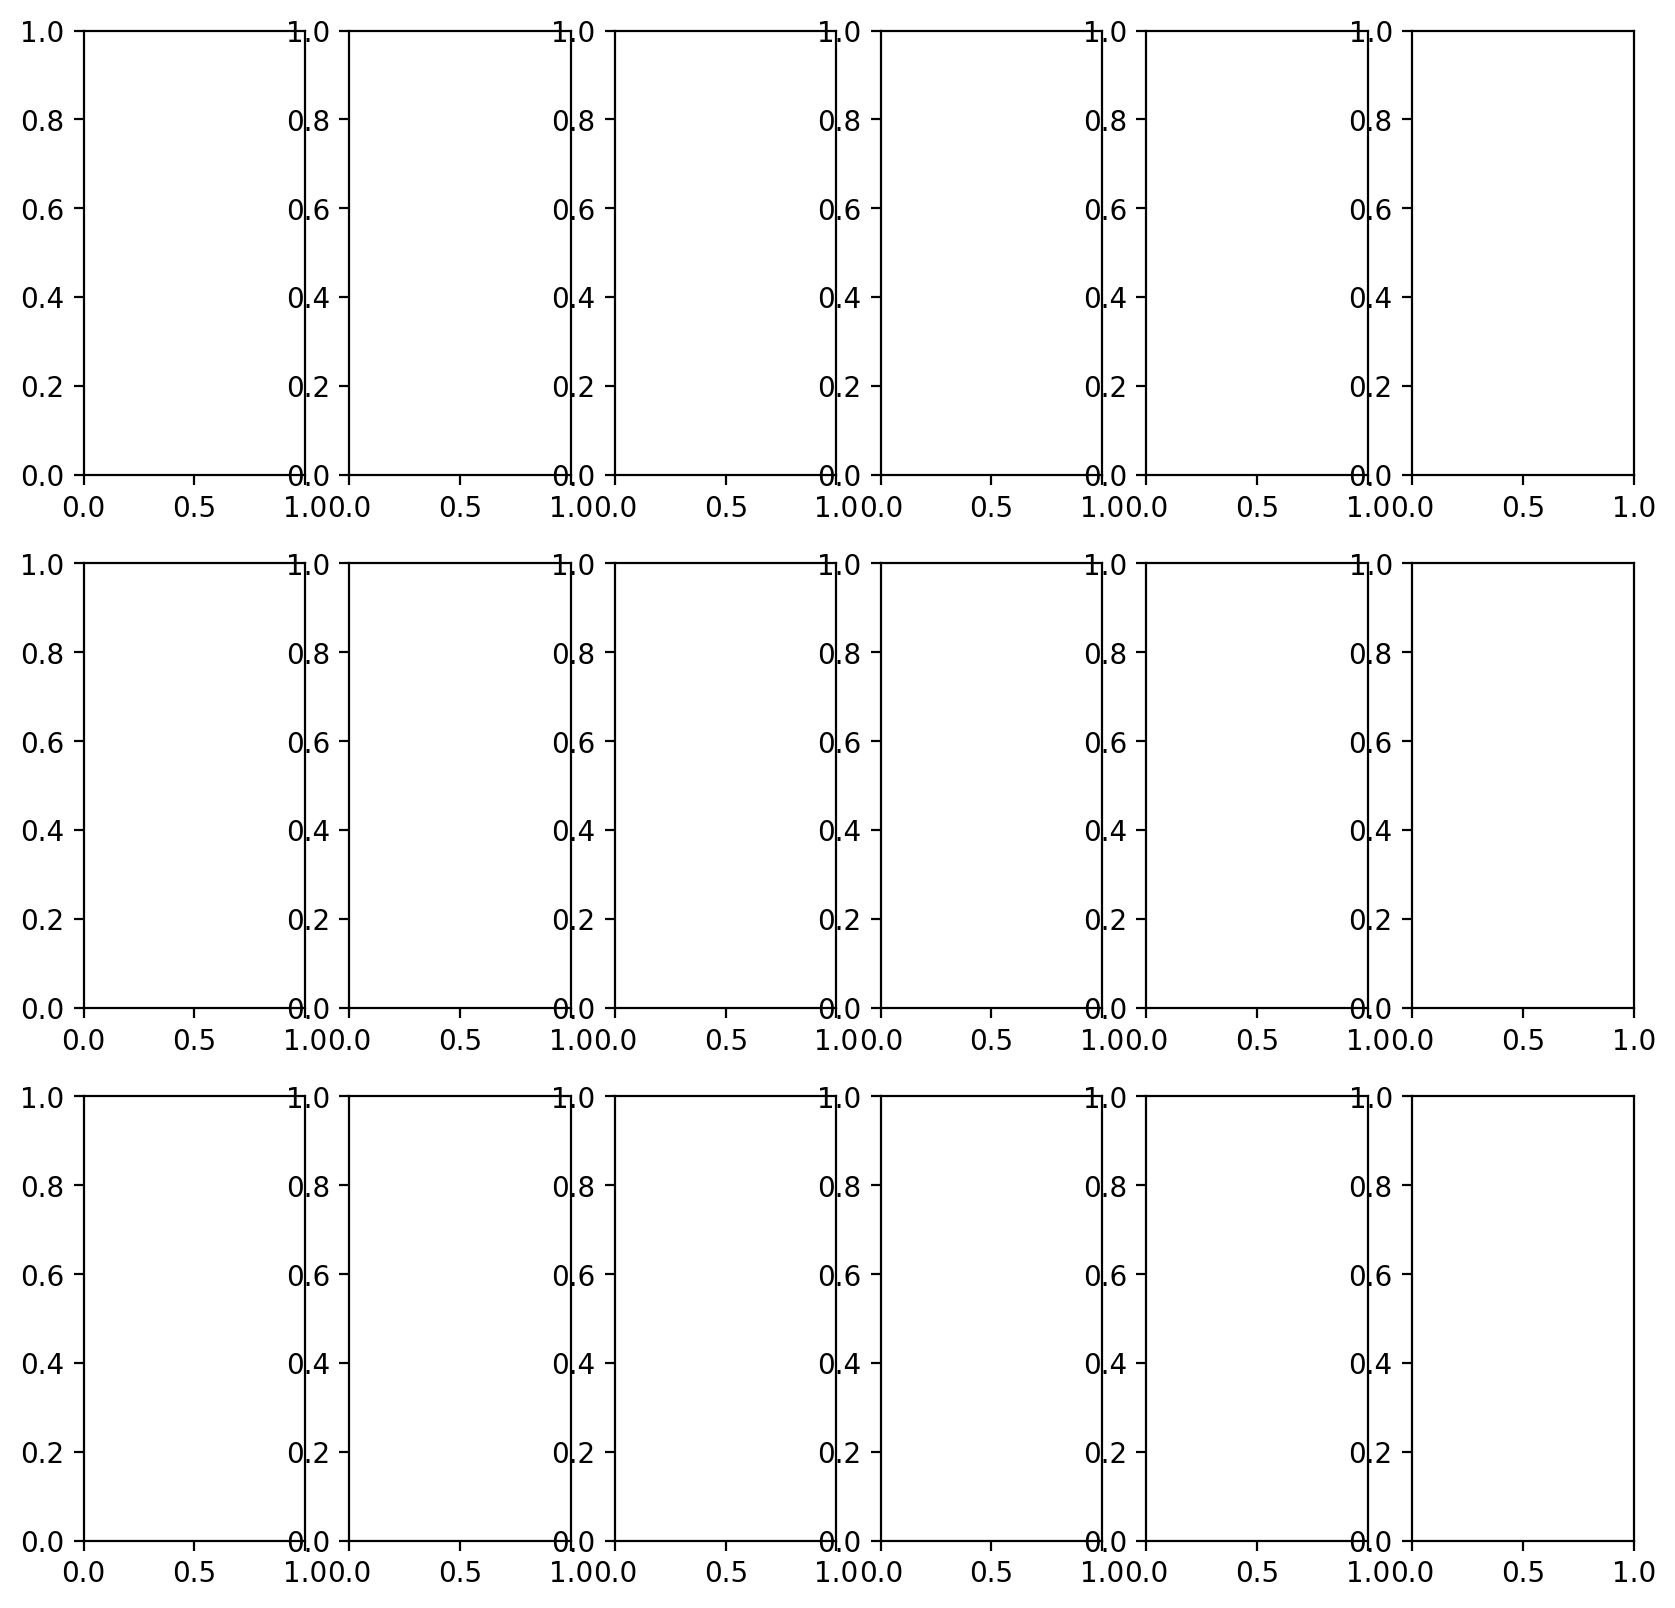

In [20]:
fig, axs = plt.subplots(3, 6, figsize=(10,10), dpi=200)
axs = axs.flatten()
for i, item in enumerate(dict_all['IMG_5994.MOV']):
    print(i, item['path'], item['img_hash_str'])
    ax = axs[i]
    try:
        image = Image.open(item['path'])
        ax.imshow(image)
    except Exception as e:
        pass


IMG_1831.JPG
DSC01170.JPG
IMG_9355.JPG
CIMG2796.JPG
IMG_2143.PNG
IMG_1795.JPG
IMG_7757.JPG
ipod 354.jpg
IMG_3031.PNG
IMG_5154.JPG


/Users/xingzhiguo/miniconda3/lib/python3.8/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


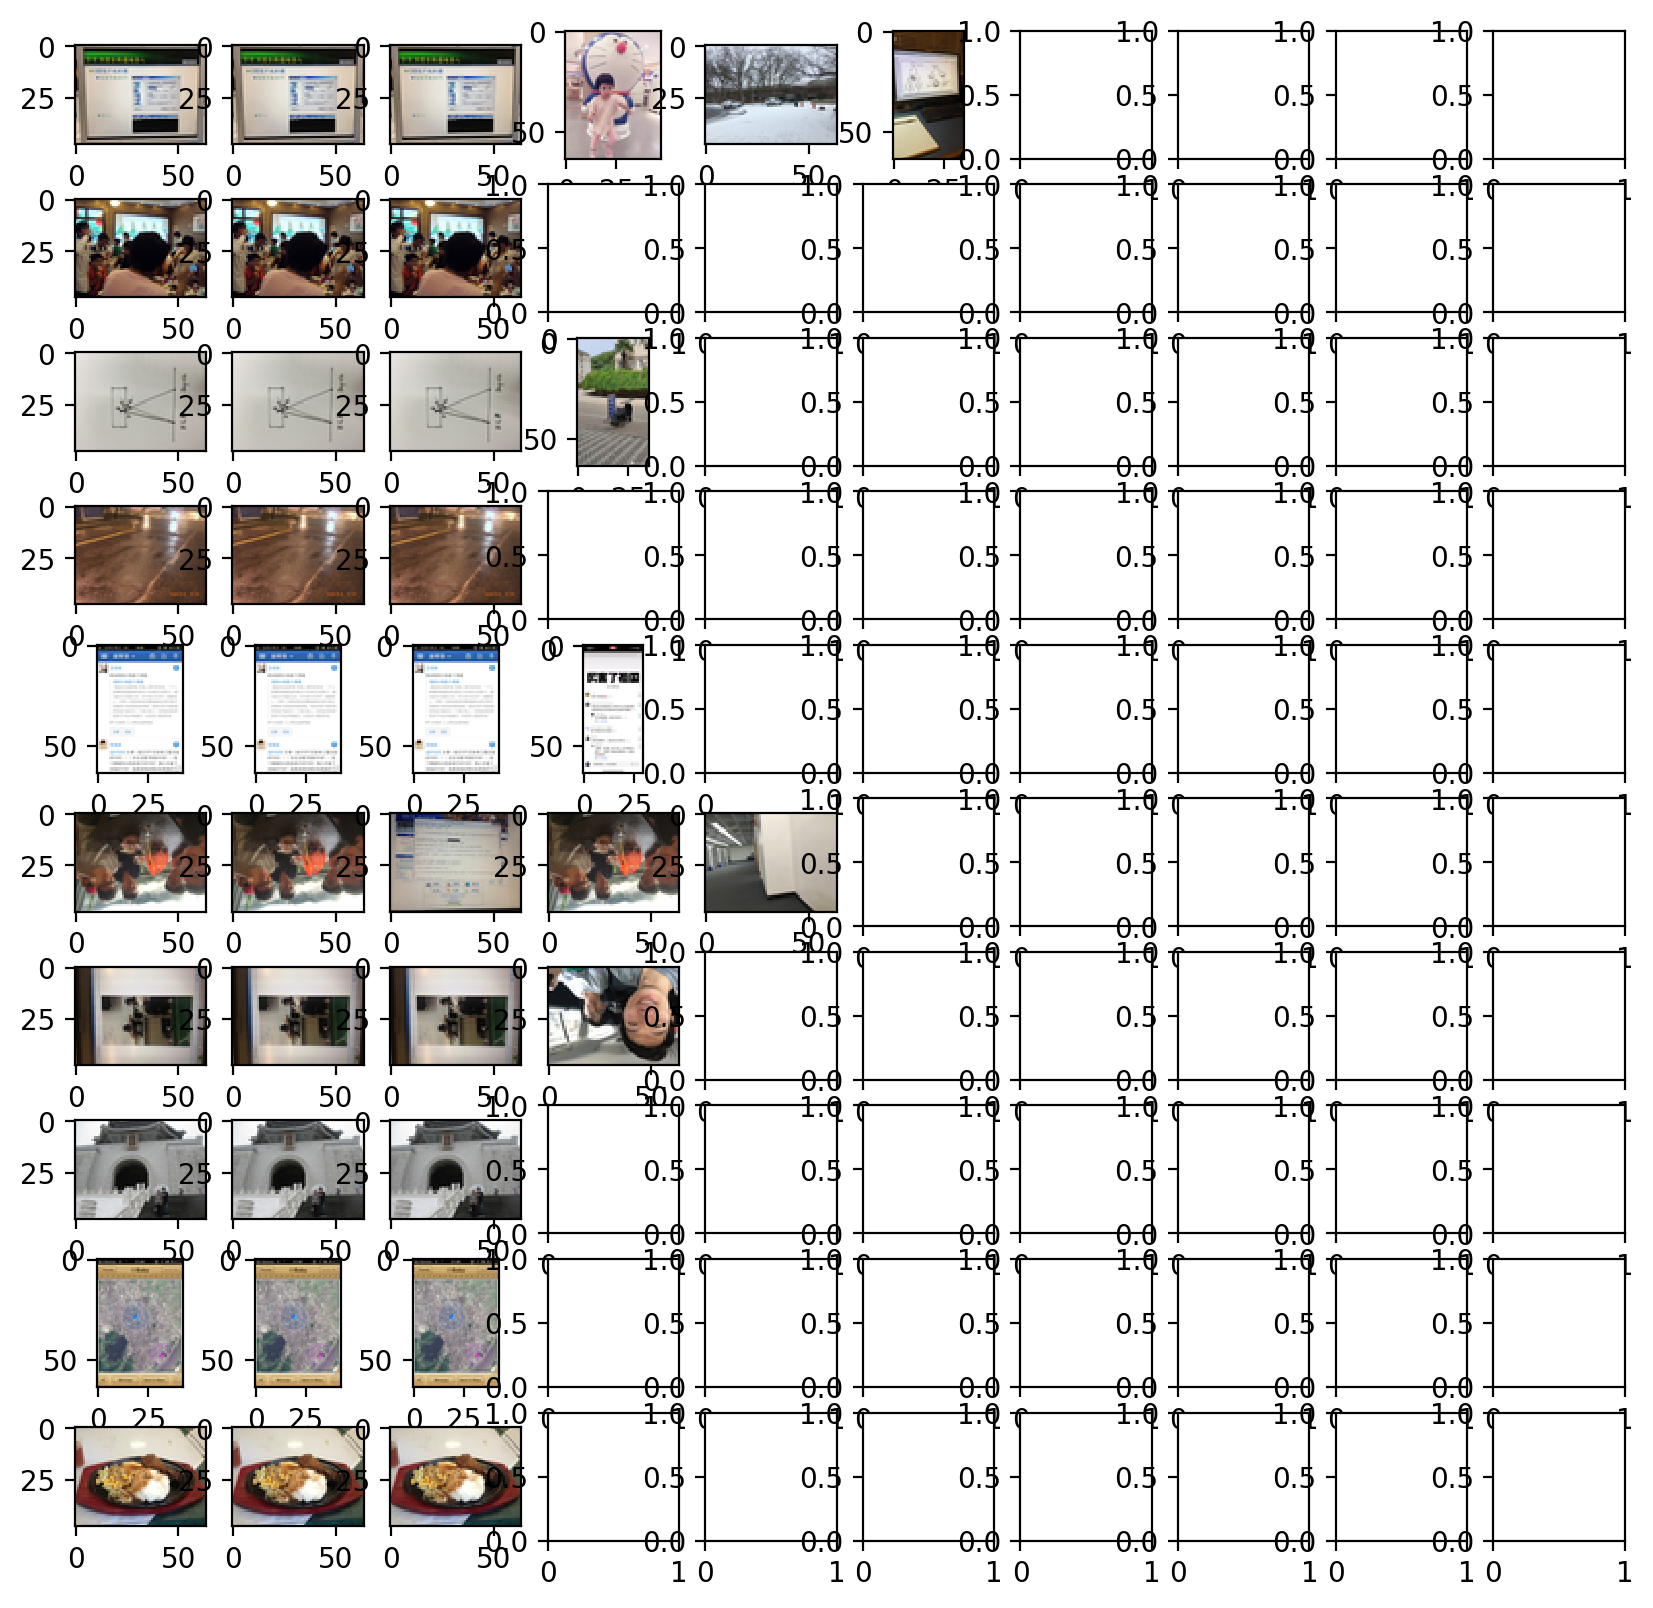

In [21]:
show_duplicate_pair = 10
choices = np.random.choice( len(duplicate_record_pairs), size= show_duplicate_pair)

fig, axs = plt.subplots(show_duplicate_pair, 10, figsize=(10,10), dpi=200)
# axs = axs.flatten()

for i, pair_id in enumerate(choices):
    ax = axs[i,0]
    item0 = duplicate_record_pairs[pair_id][0]
    print(item0['fname'])
    img = Image.open(item0['path'])
    img.thumbnail((64,64), Image.ANTIALIAS)
    ax.imshow(img)
    
    ax = axs[i,1]
    item1 = duplicate_record_pairs[pair_id][1]
    img = Image.open(item1['path'])
    img.thumbnail((64,64), Image.ANTIALIAS)
    ax.imshow(img)
    
    for j in range (len(dict_all[item0['fname']])):
        if 2+j ==10:
            break
        ax = axs[i,2+j]
        item3 = dict_all[item0['fname']][j]
        img = Image.open(item3['path'])
        img.thumbnail((64,64), Image.ANTIALIAS)
        ax.imshow(img)



(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 9.000e+00,
        0.000e+00, 5.300e+01, 4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 2.340e+02, 2.000e+00, 1.500e+01, 2.000e+01, 7.700e+01,
        2.000e+00, 4.710e+02, 5.600e+01, 3.720e+02, 1.570e+02, 4.410e+02,
        8.200e+01, 4.100e+01, 1.850e+02, 5.810e+02, 5.900e+01, 6.710e+02,
        2.390e+02, 2.000e+00, 0.000e+00, 3.300e+01, 1.430e+02, 1.000e+00,
        9.000e+00, 2.000e+00, 2.660e+02, 1.900e+01, 1.000e+00, 2.000e+00,
        2.400e+01, 0.000e+00, 1.300e+01, 1.390e+02, 3.400e+01, 1.800e+01,
        4.240e+02, 2.900e+01, 2.220e+0

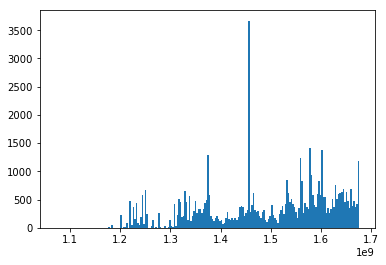

In [ ]:
mtime_list = []
for key in dict_all.keys():
    for record in dict_all[key]:
        mtime_list.append(record['mtime'])
mtime_list = np.array(mtime_list)
mtime_list = mtime_list[mtime_list>900003577.0]
plt.hist(mtime_list, bins=200)

# Copy data to new place

In [ ]:
from os.path import join as os_join
from os.path import exists  as os_exists
import os
import errno
import subprocess
from joblib import Parallel, delayed


def copy_file(record, base_folder):
    fname = record['fname']
    src_path = record['path'] 
    is_file = record['is_file']
    mtime_YYYY = record['mtime_YYYY']
    mtime_MM = record['mtime_MM']
    mtime_DD = record['mtime_DD']
    
    if not is_file:
        return False
    
    fname_post = fname.replace(" ", "_")
    save_folder = os_join(base_folder, str(mtime_YYYY), str(mtime_MM), str(mtime_DD))
    
    if not os_exists(save_folder):
        try:
            os.makedirs(save_folder)
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(save_folder):
                # File exists, and it's a directory,
                # another process beat us to creating this dir, that's OK.
                pass
            else:
                # Our target dir exists as a file, or different error,
                # reraise the error!
                raise

    save_file_path = os_join(save_folder,fname_post)
    
    while True:
        if os_exists(save_file_path):
            # rename 
            fname_name, fname_ext = fname_post.rsplit('.', 1)
            fname_name_new = fname_name+f'-{np.random.randint(1,100)}'+'.'+fname_ext
            save_file_path = os_join(save_folder,fname_name_new)
        else:
            break
    # print(src_path, '-->',save_file_path)
    subprocess.call(["rsync", "-a", src_path, save_file_path])
    
    return True

    # shutil.copy2(src_path, save_file_path)
    # shutil.copystat(src_path, save_file_path)
# copystat() 


def copy_key_file(records, base_folder):
    num_records = 0
    for record in records:
        copy_file(record, base_folder)
        num_records+=1
    return num_records

n_cpus = 4
base_folder = '/Volumes/ssd-0/old-photo-organize/old-merged-file-20230221'
num_output_file = 0
num_output_file_list = Parallel(n_jobs=n_cpus)(delayed(copy_key_file)(dict_all[key],base_folder) for key in tqdm(dict_all.keys()))



# for key in tqdm(dict_all.keys()):
#     for record in dict_all[key]:
#         # print(record)
#         copy_file(record, base_folder)
#         num_output_file+=1
# print(num_output_file)


  0%|          | 0/38786 [00:00<?, ?it/s]

TypeError: 'int' object is not iterable

In [ ]:
print('total copied records:', sum(num_output_file_list))


total copied records: 55698


## get (1) duplicate problem 

In [132]:
import glob
import os 
from os.path import isfile as os_file
from os.path import isdir as os_dir
from os.path import basename as os_base

from os import stat as os_stat
import pathlib
from tqdm import tqdm as tqdm
import datetime


base_path = '/Volumes/ssd-0/old-photo-organize/old-merged-file-20230221/2023/**'


def get_all_files(base_path):
    records = []
    for filepath in tqdm(glob.iglob(base_path, recursive=True)):
        # print(filepath)
        
        file_extension = pathlib.Path(filepath).suffix
        file_name = os_base(filepath)
        is_dir = os_dir(filepath)
        is_file = os_file(filepath)
        file_size = os.path.getsize(filepath)
        
        
        record = {
            "fname": file_name,
            "filename":file_name.split(".")[0],
            "filename_clear":file_name.split(".")[0].replace("(1)", ""),
            "ext":file_extension,
            "size":file_size,
            "is_dir": is_dir,
            "is_file":is_file,
            "path": filepath,
        }
        if is_file:
            records.append(record)
    
    return records


records = get_all_files(base_path)

1306it [00:00, 4829.96it/s]


In [133]:
df_records = pd.DataFrame.from_records(records)
print(df_records.shape)

(1260, 8)


In [134]:
dict_record_by_clear_name = {}
for record in records:
    clear_fname_ext = (record['filename_clear'],record['ext'])
    if clear_fname_ext not in dict_record_by_clear_name.keys():
        dict_record_by_clear_name[clear_fname_ext] = []
    dict_record_by_clear_name[clear_fname_ext].append(record)
    


def dedup_records(records):
    if len(records) == 1:
        return records[-1]
    records_by_size = sorted(records, key=lambda x:x['size'])
    return records_by_size[-1]
    
records_dedup = []
for key in dict_record_by_clear_name.keys():
    best_record = dedup_records(dict_record_by_clear_name[key])
    records_dedup.append(best_record)
df_best_records = pd.DataFrame.from_records(records_dedup)

print(df_best_records.shape)
retain_path_set = set(df_best_records["path"].to_list())
print(len(retain_path_set))
df_remove_records = df_records[~df_records['path'].isin(retain_path_set)]
print(df_remove_records.shape)

(1258, 8)
1258
(2, 8)


In [139]:
df_remove_records.sample(2)

,fname,filename,filename_clear,ext,size,is_dir,is_file,path
832,FullSizeRender.MP4,FullSizeRender,FullSizeRender,.MP4,1650410,False,True,/Volumes/ssd-0/old-photo-organize/old-merged-f...
725,IMG_0436(1).MP4,IMG_0436(1),IMG_0436,.MP4,5005693,False,True,/Volumes/ssd-0/old-photo-organize/old-merged-f...


### Move 

In [131]:
save_file_path = '/Volumes/ssd-0/old-photo-organize/old-merge-deduplicate/'
for src_path in tqdm(df_remove_records['path']):
    # print(["mv", src_path, save_file_path])
    subprocess.call(["mv", src_path, save_file_path])

100%|██████████| 1059/1059 [00:22<00:00, 46.61it/s]
